In [53]:
import numpy as np
import pandas as pd
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# KPEC Time-series chart 로딩

In [2]:
df1 = pd.read_csv('./data/220114/220114 time_series_chart.csv', parse_dates = True)

In [3]:
df1['DateTime']= pd.to_datetime(df1['DateTime'])

In [4]:
df1=df1[(df1['DateTime']<'2022-01-01 00:00:00')]

In [5]:
df1

,DateTime,energyTotalProduce,energyTotalConsume,ToESS(We),ESSout(We),energyTotalSelfConsumeRate,energyTotalSelfRate,SCF,LCF,SCF_acc,LCF_acc
19583,2021-12-31 23:59:00,364,15920,0.0,0.0,1.0,0.787195,1.0,0.022864,0.505157,0.397077
19584,2021-12-31 23:58:00,364,15681,0.0,0.0,1.0,0.787201,1.0,0.023213,0.505157,0.397080
19585,2021-12-31 23:57:00,365,14987,0.0,0.0,1.0,0.787208,1.0,0.024354,0.505157,0.397084
19586,2021-12-31 23:56:00,365,13738,0.0,0.0,1.0,0.787214,1.0,0.026569,0.505156,0.397087
19587,2021-12-31 23:55:00,365,12459,0.0,0.0,1.0,0.787220,1.0,0.029296,0.505156,0.397089
...,...,...,...,...,...,...,...,...,...,...,...
160470,2021-09-13 00:17:00,10,7728,0.0,0.0,1.0,0.001555,1.0,0.001294,1.000000,0.001555
160471,2021-09-13 00:15:00,10,8105,0.0,0.0,1.0,0.001573,1.0,0.001234,1.000000,0.001573
160472,2021-09-13 00:11:00,10,6271,0.0,0.0,1.0,0.001601,1.0,0.001595,1.000000,0.001601
160473,2021-09-13 00:06:00,10,5711,0.0,0.0,1.0,0.001602,1.0,0.001751,1.000000,0.001602


In [6]:
df1=df1.set_index('DateTime')

# ESS충방전량 추출

In [7]:
df2 = pd.read_csv('./data/220114/220114 kepsh1.csv', parse_dates = True)

In [8]:
df2['DateTime']= pd.to_datetime(df2['DateTime'])

In [9]:
df2=df2[(df2['DateTime']>='2021-09-13 00:00:00')]

In [10]:
df2=df2[(df2['DateTime']<'2022-01-01 00:00:00')]

In [11]:
df2=df2.set_index('DateTime')

In [12]:
df2

,ESS_Power(W),Pvt_Supply(W),Pv_Supply(W),Heatpump_Load(W),FuelCell_Supply(W),Total_Consumption(W),Total_Production(W)
DateTime,,,,,,,
2021-12-31 23:59:00,0.0,-9.0,-50.0,68.0,364.0,1285,364
2021-12-31 23:58:00,0.0,-9.0,-50.0,66.0,364.0,1276,364
2021-12-31 23:57:00,0.0,-9.0,-50.0,74.0,365.0,1283,365
2021-12-31 23:56:00,0.0,-9.0,-50.0,191.0,365.0,1400,365
2021-12-31 23:55:00,0.0,-9.0,-50.0,190.0,365.0,1396,365
...,...,...,...,...,...,...,...
2021-09-13 00:06:00,0.0,9.0,-49.0,29.0,0.0,797,9
2021-09-13 00:05:00,0.0,9.0,-49.0,28.0,0.0,806,9
2021-09-13 00:04:00,0.0,9.0,-49.0,29.0,0.0,780,9


# KPEC 설비간 에너지흐름차트 로딩

In [13]:
df3 = pd.read_csv('./data/220114/220114 facility_energy_flow.csv', parse_dates = True)

In [14]:
df3['DateTime']= pd.to_datetime(df3['DateTime'])

In [15]:
df3=df3[(df3['DateTime']<'2022-01-01 00:00:00')]

In [16]:
df3=df3.set_index('DateTime')

In [17]:
df3

,PVout(We),PVTout(We),FCout(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),ToESS(We),ESSout(We),ESS2Grid(We),...,GSHP2HTES(Wt),ASHP2Cool(Wt),ASHP2Heat(Wt),CTES2Cool(Wt),HTES2Heat(Wt),HTES2Water(Wt),DirectElec(We),CoolLoad(Wt),HeatLoad(Wt),HotwaterLoad(Wt)
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:59:00,-83.166,-75.517,364.417,10656.00,1465.33,15556.0,0.0,0.0,0.0,0.0,...,1361.88,0.0,1261.00,0.00,0.0,0.0,12121.30,0.00,1261.00,0.0
2021-12-31 23:58:00,-83.633,-75.517,364.100,10446.40,1439.10,15317.0,0.0,0.0,0.0,0.0,...,1373.42,0.0,1259.58,0.00,0.0,0.0,11885.50,0.00,1259.58,0.0
2021-12-31 23:57:00,-83.396,-75.603,365.293,9691.78,1492.24,14622.0,0.0,0.0,0.0,0.0,...,1403.40,0.0,1253.80,0.00,0.0,0.0,11184.00,0.00,1253.80,0.0
2021-12-31 23:56:00,-83.667,-76.600,365.033,8201.47,1616.77,13373.0,0.0,0.0,0.0,0.0,...,1392.91,0.0,1252.67,0.00,0.0,0.0,9818.23,0.00,1252.67,0.0
2021-12-31 23:55:00,-83.373,-75.797,365.339,6983.00,1553.71,12094.0,0.0,0.0,0.0,0.0,...,1347.38,0.0,1260.17,0.00,0.0,0.0,8536.71,0.00,1260.17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 00:17:00,-78.000,10.000,0.000,5304.00,1026.00,7718.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,2730.33,0.0,0.0,6330.00,2730.33,0.00,0.0
2021-09-13 00:15:00,-82.000,10.000,0.000,5614.00,1060.00,8095.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,3222.91,0.0,0.0,6674.00,3222.91,0.00,0.0
2021-09-13 00:11:00,-80.000,10.000,0.000,4922.00,1092.00,6261.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.0,0.0,6014.00,0.00,0.00,0.0


# KPEC 건물간 에너지흐름차트 로딩

In [20]:
df4 = pd.read_csv('./data/220114/220114 building_information.csv', parse_dates = True)

In [21]:
df4['DateTime']= pd.to_datetime(df4['DateTime'])

In [22]:
df4=df4[(df4['DateTime']<'2022-01-01 00:00:00')]

In [24]:
df4=df4.set_index('DateTime')

# KPEC 데이터 합치기

In [26]:
df_kpec = pd.DataFrame()
df_kpec = pd.DataFrame(pd.date_range('2021-09-13 00:00:00', '2021-12-31 23:59:00', freq='T'), columns=['Time'])

In [27]:
df_kpec

,Time
0,2021-09-13 00:00:00
1,2021-09-13 00:01:00
2,2021-09-13 00:02:00
3,2021-09-13 00:03:00
4,2021-09-13 00:04:00
...,...
158395,2021-12-31 23:55:00
158396,2021-12-31 23:56:00
158397,2021-12-31 23:57:00
158398,2021-12-31 23:58:00


In [28]:
df_kpec = df_kpec.set_index('Time')

In [29]:
df_kpec['Cons_kpec(W)'] = df1['energyTotalConsume']
df_kpec['Prod_kpec(W)'] = df1['energyTotalProduce']
df_kpec['ESS_kpec(W)'] = df2['ESS_Power(W)']*(-1)

In [30]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W)
Time,,,
2021-09-13 00:00:00,NaN,NaN,-0.0
2021-09-13 00:01:00,NaN,NaN,NaN
2021-09-13 00:02:00,NaN,NaN,NaN
2021-09-13 00:03:00,6440.0,10.0,-0.0
2021-09-13 00:04:00,NaN,NaN,-0.0
...,...,...,...
2021-12-31 23:55:00,12459.0,365.0,-0.0
2021-12-31 23:56:00,13738.0,365.0,-0.0
2021-12-31 23:57:00,14987.0,365.0,-0.0


In [31]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158400 entries, 2021-09-13 00:00:00 to 2021-12-31 23:59:00
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Cons_kpec(W)  140503 non-null  float64
 1   Prod_kpec(W)  140503 non-null  float64
 2   ESS_kpec(W)   141895 non-null  float64
dtypes: float64(3)
memory usage: 4.8 MB


In [32]:
df_kpec['PV_kpec(We)'] = df3['PVout(We)']
df_kpec['PVT_kpec(We)'] = df3['PVTout(We)']
df_kpec['FC_kpec(We)'] = df3['FCout(We)']
df_kpec['PlugLoad(We)'] = df3['PlugLoad(We)']
df_kpec['LightLoad(We)'] = df3['LightLoad(We)']
df_kpec['FromGrid(We)'] = df3['FromGrid(We)']
df_kpec['ToGrid(We)'] = df3['ToGrid(We)']
df_kpec['ToESS(We)'] = df3['ToESS(We)']
df_kpec['ESSout(We)'] = df3['ESSout(We)']
df_kpec['ESS2Grid(We)'] = df3['ESS2Grid(We)']
df_kpec['ESS2ASHP(We)'] = df3['ESS2ASHP(We)']
df_kpec['ESS2GSHP(We)'] = df3['ESS2GSHP(We)']
df_kpec['Grid2ASHP(We)'] = df3['Grid2ASHP(We)']
df_kpec['Grid2GSHP(We)'] = df3['Grid2GSHP(We)']
df_kpec['PVTHout(Wt)'] = df3['PVTHout(Wt)']
df_kpec['FCHout(Wt)'] = df3['FCHout(Wt)']
df_kpec['ASHP2HTES(Wt)'] = df3['ASHP2HTES(Wt)']
df_kpec['GSHP2CTES(Wt)'] = df3['GSHP2CTES(Wt)']
df_kpec['GSHP2HTES(Wt)'] = df3['GSHP2HTES(Wt)']
df_kpec['ASHP2Cool(Wt)'] = df3['ASHP2Cool(Wt)']
df_kpec['ASHP2Heat(Wt)'] = df3['ASHP2Heat(Wt)']
df_kpec['CTES2Cool(Wt)'] = df3['CTES2Cool(Wt)']
df_kpec['HTES2Heat(Wt)'] = df3['HTES2Heat(Wt)']
df_kpec['HTES2Water(Wt)'] = df3['HTES2Water(Wt)']
df_kpec['DirectElec(We)'] = df3['DirectElec(We)']
df_kpec['CoolLoad(Wt)'] = df3['CoolLoad(Wt)']
df_kpec['HeatLoad(Wt)'] = df3['HeatLoad(Wt)']
df_kpec['HotwaterLoad(Wt)'] = df3['HotwaterLoad(Wt)']

In [33]:
df_kpec['PV_kpec(We)'] = np.where(df_kpec['PV_kpec(We)']<0, 0, df_kpec['PV_kpec(We)'])
df_kpec['PVT_kpec(We)'] = np.where(df_kpec['PVT_kpec(We)']<0, 0, df_kpec['PVT_kpec(We)'])
df_kpec['FC_kpec(We)'] = np.where(df_kpec['FC_kpec(We)']<0, 0, df_kpec['FC_kpec(We)'])
df_kpec['PlugLoad(We)'] = np.where(df_kpec['PlugLoad(We)']<0, 0, df_kpec['PlugLoad(We)'])

In [34]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*1/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*1/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*1/3600

df_kpec['PV_acc_kpec(Wh)'] = df_kpec['PV_kpec(We)'].cumsum()*60*1/3600
df_kpec['PVT_acc_kpec(Wh)'] = df_kpec['PVT_kpec(We)'].cumsum()*60*1/3600
df_kpec['FC_acc_kpec(Wh)'] = df_kpec['FC_kpec(We)'].cumsum()*60*1/3600
df_kpec['PlugLoad_acc(Wh)'] = df_kpec['PlugLoad(We)'].cumsum()*60*1/3600
df_kpec['LightLoad_acc(Wh)'] = df_kpec['LightLoad(We)'].cumsum()*60*1/3600
df_kpec['FromGrid_acc(Wh)'] = df_kpec['FromGrid(We)'].cumsum()*60*1/3600
df_kpec['ToGrid_acc(Wh)'] = df_kpec['ToGrid(We)'].cumsum()*60*1/3600
df_kpec['ToESS_acc(Wh)'] = df_kpec['ToESS(We)'].cumsum()*60*1/3600
df_kpec['ESSout_acc(Wh)'] = df_kpec['ESSout(We)'].cumsum()*60*1/3600
df_kpec['ESS2Grid_acc(Wh)'] = df_kpec['ESS2Grid(We)'].cumsum()*60*1/3600
df_kpec['ESS2ASHP_acc(Wh)'] = df_kpec['ESS2ASHP(We)'].cumsum()*60*1/3600
df_kpec['ESS2GSHP_acc(Wh)'] = df_kpec['ESS2GSHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2ASHP_acc(Wh)'] = df_kpec['Grid2ASHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2GSHP_acc(Wh)'] = df_kpec['Grid2GSHP(We)'].cumsum()*60*1/3600
df_kpec['PVTHout_acc(Wh)'] = df_kpec['PVTHout(Wt)'].cumsum()*60*1/3600
df_kpec['FCHout_acc(Wh)'] = df_kpec['FCHout(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2HTES_acc(Wh)'] = df_kpec['ASHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2CTES_acc(Wh)'] = df_kpec['GSHP2CTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2HTES_acc(Wh)'] = df_kpec['GSHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Cool_acc(Wh)'] = df_kpec['ASHP2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Heat_acc(Wh)'] = df_kpec['ASHP2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['CTES2Cool_acc(Wh)'] = df_kpec['CTES2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Heat_acc(Wh)'] = df_kpec['HTES2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Water_acc(Wh)'] = df_kpec['HTES2Water(Wt)'].cumsum()*60*1/3600
df_kpec['DirectElec_acc(Wh)'] = df_kpec['DirectElec(We)'].cumsum()*60*1/3600
df_kpec['CoolLoad_acc(Wh)'] = df_kpec['CoolLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HeatLoad_acc(Wh)'] = df_kpec['HeatLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HotwaterLoad_acc(Wh)'] = df_kpec['HotwaterLoad(Wt)'].cumsum()*60*1/3600

In [35]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(We)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*1/3600

In [36]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

In [37]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

In [38]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

In [39]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

In [40]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158400 entries, 2021-09-13 00:00:00 to 2021-12-31 23:59:00
Data columns (total 72 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Cons_kpec(W)          140503 non-null  float64
 1   Prod_kpec(W)          140503 non-null  float64
 2   ESS_kpec(W)           141895 non-null  float64
 3   PV_kpec(We)           140503 non-null  float64
 4   PVT_kpec(We)          140503 non-null  float64
 5   FC_kpec(We)           140503 non-null  float64
 6   PlugLoad(We)          140503 non-null  float64
 7   LightLoad(We)         140503 non-null  float64
 8   FromGrid(We)          140503 non-null  float64
 9   ToGrid(We)            140503 non-null  float64
 10  ToESS(We)             140503 non-null  float64
 11  ESSout(We)            140503 non-null  float64
 12  ESS2Grid(We)          140503 non-null  float64
 13  ESS2ASHP(We)          140503 non-null  float64
 14  ESS2GSHP(We)      

In [41]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),PV_kpec(We),PVT_kpec(We),FC_kpec(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),...,E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:00:00,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:03:00,6440.0,10.0,-0.0,0.0,10.0,0.000,4959.00,1225.00,6430.0,0.0,...,10.0,1.666667e-01,10.0,1.666667e-01,1.0,0.001553,1.000000,0.001553,0.001553,0.500776
2021-09-13 00:04:00,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:55:00,12459.0,365.0,-0.0,0.0,0.0,365.339,6983.00,1553.71,12094.0,0.0,...,365.0,1.181679e+07,365.0,1.181679e+07,1.0,0.029296,0.498434,0.388323,0.780290,0.443378
2021-12-31 23:56:00,13738.0,365.0,-0.0,0.0,0.0,365.033,8201.47,1616.77,13373.0,0.0,...,365.0,1.181680e+07,365.0,1.181680e+07,1.0,0.026569,0.498434,0.388320,0.780284,0.443377
2021-12-31 23:57:00,14987.0,365.0,-0.0,0.0,0.0,365.293,9691.78,1492.24,14622.0,0.0,...,365.0,1.181680e+07,365.0,1.181680e+07,1.0,0.024354,0.498434,0.388317,0.780278,0.443376


In [58]:
df_kpec.to_csv('./data/220114_kpec.csv')

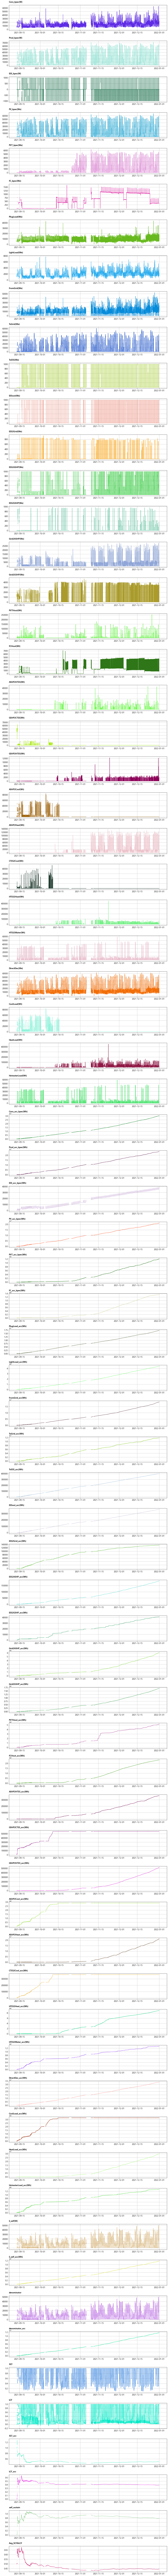

In [57]:
fig, ax = plt.subplots(figsize=(18,300))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kpec[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 주거용 건물

## KePSH1

In [97]:
data = pd.read_csv('./data/220114/220114 kepsh1.csv', parse_dates = True)

In [98]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'ESS_Power(W)', 'Pvt_Supply(W)', 'Pv_Supply(W)', 'Heatpump_Load(W)', 'FuelCell_Supply(W)', 'Total_Consumption(W)', 'Total_Production(W)']


In [99]:
df_kepsh1 = pd.DataFrame()
df_kepsh1['Time'] = data['DateTime']
df_kepsh1['PV_kepsh1(W)'] = np.where(data['Pv_Supply(W)']<0, 0, data['Pv_Supply(W)'])
df_kepsh1['PVT_kepsh1(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh1['FC(W)'] = data['FuelCell_Supply(W)']
df_kepsh1['HP_kepsh1(W)'] = data['Heatpump_Load(W)']
df_kepsh1['Cons_kepsh1(W)'] = data['Total_Consumption(W)']
df_kepsh1['Prod_kepsh1(W)'] = data['Total_Production(W)']
df_kepsh1['ESS(W)'] = data['ESS_Power(W)']*(-1)

df_kepsh1.head()


,Time,PV_kepsh1(W),PVT_kepsh1(W),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),ESS(W)
0,2022-01-14 14:39:00,11154.0,2240.0,363.0,386.0,1413,13757,-0.0
1,2022-01-14 14:38:00,11180.0,2247.0,363.0,388.0,1415,13790,-0.0
2,2022-01-14 14:37:00,11185.0,2250.0,362.0,386.0,1413,13797,-0.0
3,2022-01-14 14:36:00,11202.0,2253.0,362.0,450.0,1477,13818,-0.0
4,2022-01-14 14:35:00,11234.0,2260.0,363.0,506.0,1530,13857,-0.0


In [100]:
df_kepsh1['Time'] = pd.to_datetime(df_kepsh1['Time'])

In [101]:
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']>='2021-09-13 00:00:00') ]
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']<='2021-12-31 23:59:00') ]

In [102]:
df_kepsh1 = df_kepsh1.set_index('Time')

In [103]:
df_kepsh1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142377 entries, 2021-12-31 23:59:00 to 2021-09-13 00:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PV_kepsh1(W)    142377 non-null  float64
 1   PVT_kepsh1(W)   142377 non-null  float64
 2   FC(W)           142377 non-null  float64
 3   HP_kepsh1(W)    142377 non-null  float64
 4   Cons_kepsh1(W)  142377 non-null  int64  
 5   Prod_kepsh1(W)  142377 non-null  int64  
 6   ESS(W)          142297 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 8.7 MB


In [104]:
df_kepsh1['Cons_kepsh1(W)'] = df_kepsh1['Cons_kepsh1(W)'].astype(float)
df_kepsh1['Prod_kepsh1(W)'] = df_kepsh1['Prod_kepsh1(W)'].astype(float)

In [105]:
df_kepsh1['Cons_acc_kepsh1(Wh)'] = df_kepsh1['Cons_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['Prod_acc_kepsh1(Wh)'] = df_kepsh1['Prod_kepsh1(W)'].cumsum()*60/3600

In [106]:
df_kepsh1['PV_acc_kepsh1(Wh)'] = df_kepsh1['PV_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['PVT_acc_kepsh1(Wh)'] = df_kepsh1['PVT_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['FC_acc(Wh)'] = df_kepsh1['FC(W)'].cumsum()*60/3600

In [107]:
df_kepsh1['denominator'] = df_kepsh1.loc[:,['Cons_kepsh1(W)','Prod_kepsh1(W)']].min(axis=1)
df_kepsh1['denominator_acc'] = df_kepsh1.loc[:,['Cons_acc_kepsh1(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [108]:
df_kepsh1['SCF'] = df_kepsh1['denominator']/df_kepsh1['Prod_kepsh1(W)']
df_kepsh1['LCF'] = df_kepsh1['denominator']/df_kepsh1['Cons_kepsh1(W)']

In [109]:
df_kepsh1['SCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Prod_acc_kepsh1(Wh)']
df_kepsh1['LCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['self_sustain'] = df_kepsh1['Prod_acc_kepsh1(Wh)']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['Avg_SCF&LCF'] = (df_kepsh1['SCF_acc']+df_kepsh1['LCF_acc'])/2

In [110]:
df_kepsh1

,PV_kepsh1(W),PVT_kepsh1(W),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),ESS(W),Cons_acc_kepsh1(Wh),Prod_acc_kepsh1(Wh),PV_acc_kepsh1(Wh),PVT_acc_kepsh1(Wh),FC_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:59:00,0.0,0.0,364.0,68.0,1285.0,364.0,-0.0,2.141667e+01,6.066667e+00,0.00,0.000000,6.066667e+00,364.0,6.066667e+00,1.0,0.283268,1.000000,0.283268,0.283268,0.641634
2021-12-31 23:58:00,0.0,0.0,364.0,66.0,1276.0,364.0,-0.0,4.268333e+01,1.213333e+01,0.00,0.000000,1.213333e+01,364.0,1.213333e+01,1.0,0.285266,1.000000,0.284264,0.284264,0.642132
2021-12-31 23:57:00,0.0,0.0,365.0,74.0,1283.0,365.0,-0.0,6.406667e+01,1.821667e+01,0.00,0.000000,1.821667e+01,365.0,1.821667e+01,1.0,0.284489,1.000000,0.284339,0.284339,0.642170
2021-12-31 23:56:00,0.0,0.0,365.0,191.0,1400.0,365.0,-0.0,8.740000e+01,2.430000e+01,0.00,0.000000,2.430000e+01,365.0,2.430000e+01,1.0,0.260714,1.000000,0.278032,0.278032,0.639016
2021-12-31 23:55:00,0.0,0.0,365.0,190.0,1396.0,365.0,-0.0,1.106667e+02,3.038333e+01,0.00,0.000000,3.038333e+01,365.0,3.038333e+01,1.0,0.261461,1.000000,0.274548,0.274548,0.637274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 00:06:00,0.0,9.0,0.0,29.0,797.0,9.0,-0.0,3.815585e+06,7.087399e+06,5007752.65,653478.566667,1.343144e+06,9.0,3.815585e+06,1.0,0.011292,0.538362,1.000000,1.857487,0.769181
2021-09-13 00:05:00,0.0,9.0,0.0,28.0,806.0,9.0,-0.0,3.815599e+06,7.087399e+06,5007752.65,653478.716667,1.343144e+06,9.0,3.815599e+06,1.0,0.011166,0.538364,1.000000,1.857480,0.769182
2021-09-13 00:04:00,0.0,9.0,0.0,29.0,780.0,9.0,-0.0,3.815612e+06,7.087399e+06,5007752.65,653478.866667,1.343144e+06,9.0,3.815612e+06,1.0,0.011538,0.538366,1.000000,1.857474,0.769183


In [112]:
df_kepsh1.to_csv('./data/220114_kepsh1.csv')

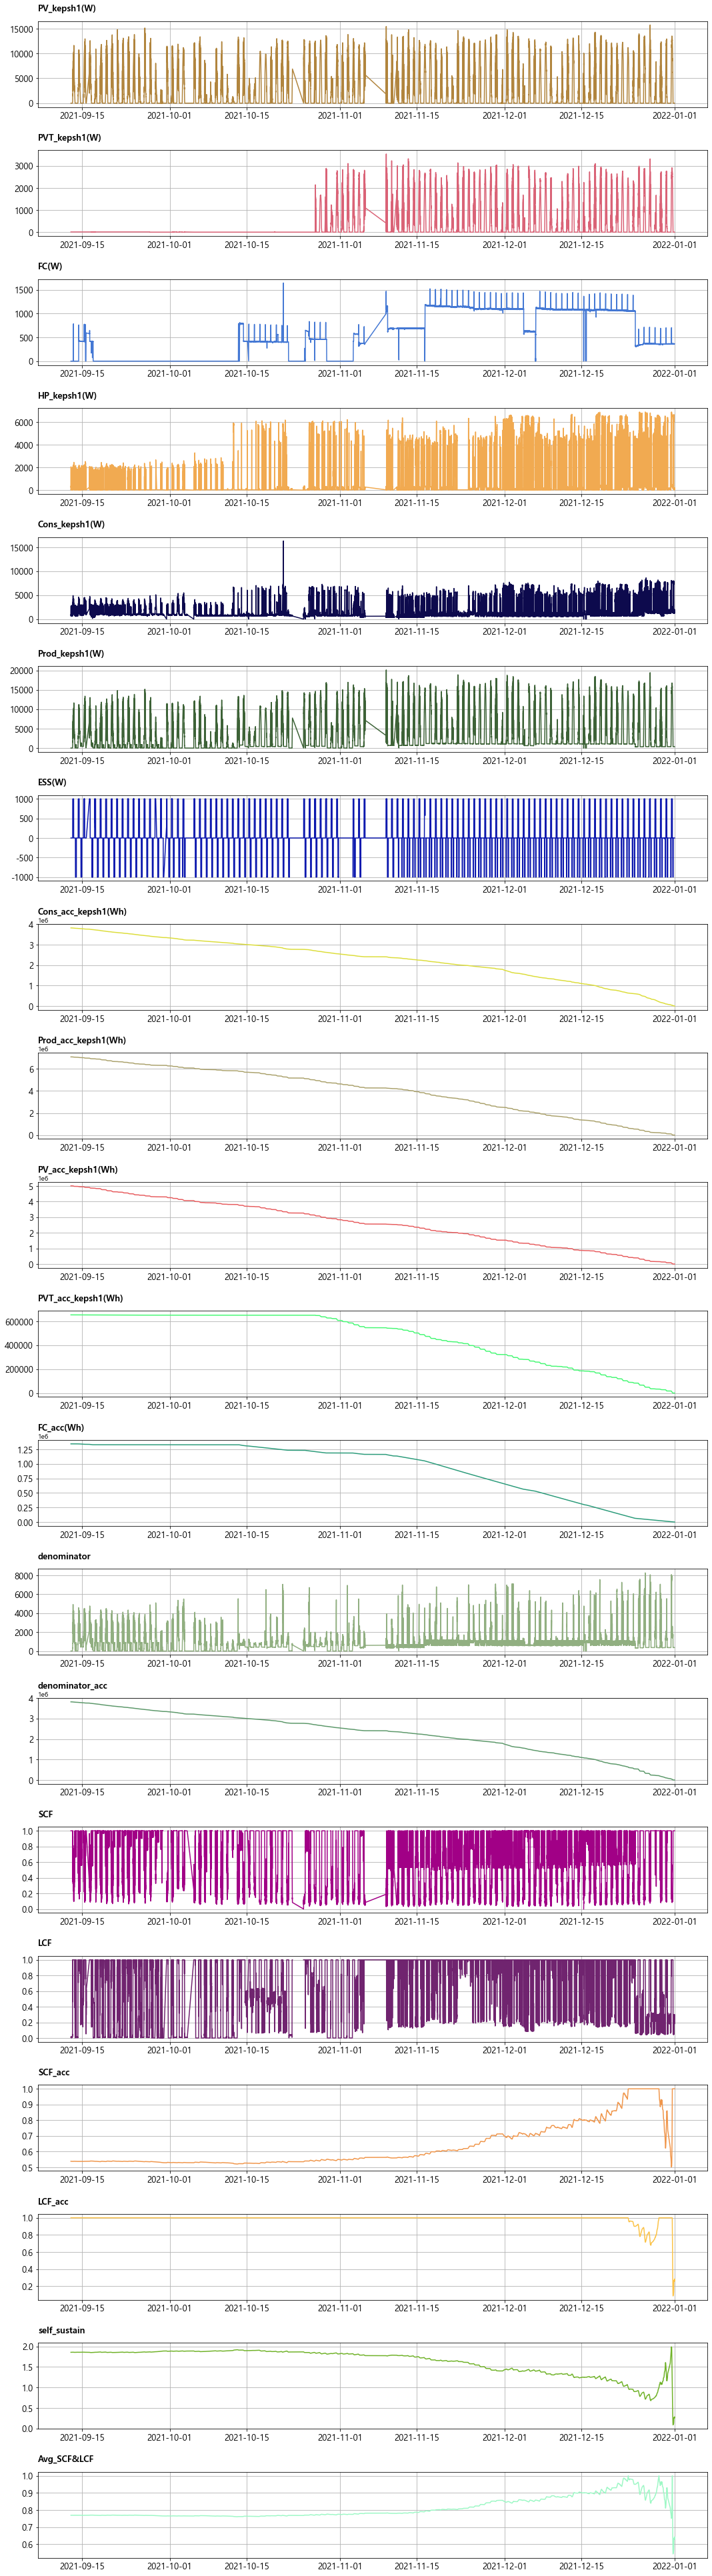

In [147]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh1.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh1[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

## KePSH2

In [116]:
data = pd.read_csv('./data/220114/220114 kepsh2.csv', parse_dates = True)

In [118]:
data

,DateTime,BIPV_Supply(W),Pvt_Supply(W),Total_Consumption(W),Total_Production(W)
0,2022-01-14 14:37:00,5489.0,1370.0,798,6859
1,2022-01-14 14:36:00,5499.0,1379.0,756,6877
2,2022-01-14 14:35:00,5519.0,1383.0,754,6902
3,2022-01-14 14:34:00,5545.0,1388.0,756,6934
4,2022-01-14 14:33:00,5567.0,1398.0,760,6965
...,...,...,...,...,...
304659,2021-05-17 10:35:00,0.0,0.0,0,0
304660,2021-05-17 10:34:00,0.0,0.0,0,0
304661,2021-05-17 10:33:00,0.0,0.0,0,0
304662,2021-05-17 10:32:00,0.0,0.0,0,0


In [121]:
df_kepsh2 = pd.DataFrame()
df_kepsh2['Time'] = data['DateTime']
# PV, PVT 음수값은 0으로 처리
df_kepsh2['PV_kepsh2(W)'] = np.where(data['BIPV_Supply(W)']<0, 0, data['BIPV_Supply(W)'])
df_kepsh2['PVT_kepsh2(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh2['Cons_kepsh2(W)'] = data['Total_Consumption(W)']
df_kepsh2['Prod_kepsh2(W)'] = data['Total_Production(W)']

df_kepsh2.head()


,Time,PV_kepsh2(W),PVT_kepsh2(W),Cons_kepsh2(W),Prod_kepsh2(W)
0,2022-01-14 14:37:00,5489.0,1370.0,798,6859
1,2022-01-14 14:36:00,5499.0,1379.0,756,6877
2,2022-01-14 14:35:00,5519.0,1383.0,754,6902
3,2022-01-14 14:34:00,5545.0,1388.0,756,6934
4,2022-01-14 14:33:00,5567.0,1398.0,760,6965


In [122]:
df_kepsh2['Time'] = pd.to_datetime(df_kepsh2['Time'])

In [123]:
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']>='2021-09-13 00:00:00') ]
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']<='2021-12-31 23:59:00') ]

In [124]:
df_kepsh2['Cons_kepsh2(W)'] = df_kepsh2['Cons_kepsh2(W)'].astype(float)
df_kepsh2['Prod_kepsh2(W)'] = df_kepsh2['Prod_kepsh2(W)'].astype(float)

In [125]:
df_kepsh2 = df_kepsh2.set_index('Time')

In [126]:
df_kepsh2['Cons_acc_kepsh2(Wh)'] = df_kepsh2['Cons_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['Prod_acc_kepsh2(Wh)'] = df_kepsh2['Prod_kepsh2(W)'].cumsum()*60/3600

In [127]:
df_kepsh2['PV_acc_kepsh2(Wh)'] = df_kepsh2['PV_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['PVT_acc_kepsh2(Wh)'] = df_kepsh2['PVT_kepsh2(W)'].cumsum()*60/3600

In [128]:
df_kepsh2['denominator'] = df_kepsh2.loc[:,['Cons_kepsh2(W)','Prod_kepsh2(W)']].min(axis=1)
df_kepsh2['denominator_acc'] = df_kepsh2.loc[:,['Cons_acc_kepsh2(Wh)','Prod_acc_kepsh2(Wh)']].min(axis=1)

In [129]:
df_kepsh2['SCF'] = df_kepsh2['denominator']/df_kepsh2['Prod_kepsh2(W)']
df_kepsh2['LCF'] = df_kepsh2['denominator']/df_kepsh2['Cons_kepsh2(W)']

In [130]:
df_kepsh2['SCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Prod_acc_kepsh2(Wh)']
df_kepsh2['LCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['self_sustain'] = df_kepsh2['Prod_acc_kepsh2(Wh)']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['Avg_SCF&LCF'] = (df_kepsh2['SCF_acc']+df_kepsh2['LCF_acc'])/2

In [131]:
df_kepsh2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142326 entries, 2021-12-31 23:59:00 to 2021-09-13 00:00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   PV_kepsh2(W)         142325 non-null  float64
 1   PVT_kepsh2(W)        142325 non-null  float64
 2   Cons_kepsh2(W)       142326 non-null  float64
 3   Prod_kepsh2(W)       142326 non-null  float64
 4   Cons_acc_kepsh2(Wh)  142326 non-null  float64
 5   Prod_acc_kepsh2(Wh)  142326 non-null  float64
 6   PV_acc_kepsh2(Wh)    142325 non-null  float64
 7   PVT_acc_kepsh2(Wh)   142325 non-null  float64
 8   denominator          142326 non-null  float64
 9   denominator_acc      142326 non-null  float64
 10  SCF                  70339 non-null   float64
 11  LCF                  142305 non-null  float64
 12  SCF_acc              141913 non-null  float64
 13  LCF_acc              142326 non-null  float64
 14  self_sustain         142326 non-nu

In [134]:
df_kepsh2

,PV_kepsh2(W),PVT_kepsh2(W),Cons_kepsh2(W),Prod_kepsh2(W),Cons_acc_kepsh2(Wh),Prod_acc_kepsh2(Wh),PV_acc_kepsh2(Wh),PVT_acc_kepsh2(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,
2021-12-31 23:59:00,0.0,0.0,3694.0,0.0,6.156667e+01,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,NaN,0.000000,NaN,0.0,0.000000,NaN
2021-12-31 23:58:00,0.0,0.0,3646.0,0.0,1.223333e+02,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,NaN,0.000000,NaN,0.0,0.000000,NaN
2021-12-31 23:57:00,0.0,0.0,3699.0,0.0,1.839833e+02,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,NaN,0.000000,NaN,0.0,0.000000,NaN
2021-12-31 23:56:00,0.0,0.0,3686.0,0.0,2.454167e+02,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,NaN,0.000000,NaN,0.0,0.000000,NaN
2021-12-31 23:55:00,0.0,0.0,3684.0,0.0,3.068167e+02,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,NaN,0.000000,NaN,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 00:08:00,0.0,1.0,204.0,1.0,2.857468e+06,3.232819e+06,2.837351e+06,395437.450000,1.0,2.857468e+06,1.0,0.004902,0.883894,1.0,1.131358,0.941947
2021-09-13 00:07:00,0.0,1.0,198.0,1.0,2.857472e+06,3.232819e+06,2.837351e+06,395437.466667,1.0,2.857472e+06,1.0,0.005051,0.883895,1.0,1.131357,0.941947
2021-09-13 00:06:00,0.0,1.0,188.0,1.0,2.857475e+06,3.232819e+06,2.837351e+06,395437.483333,1.0,2.857475e+06,1.0,0.005319,0.883896,1.0,1.131355,0.941948


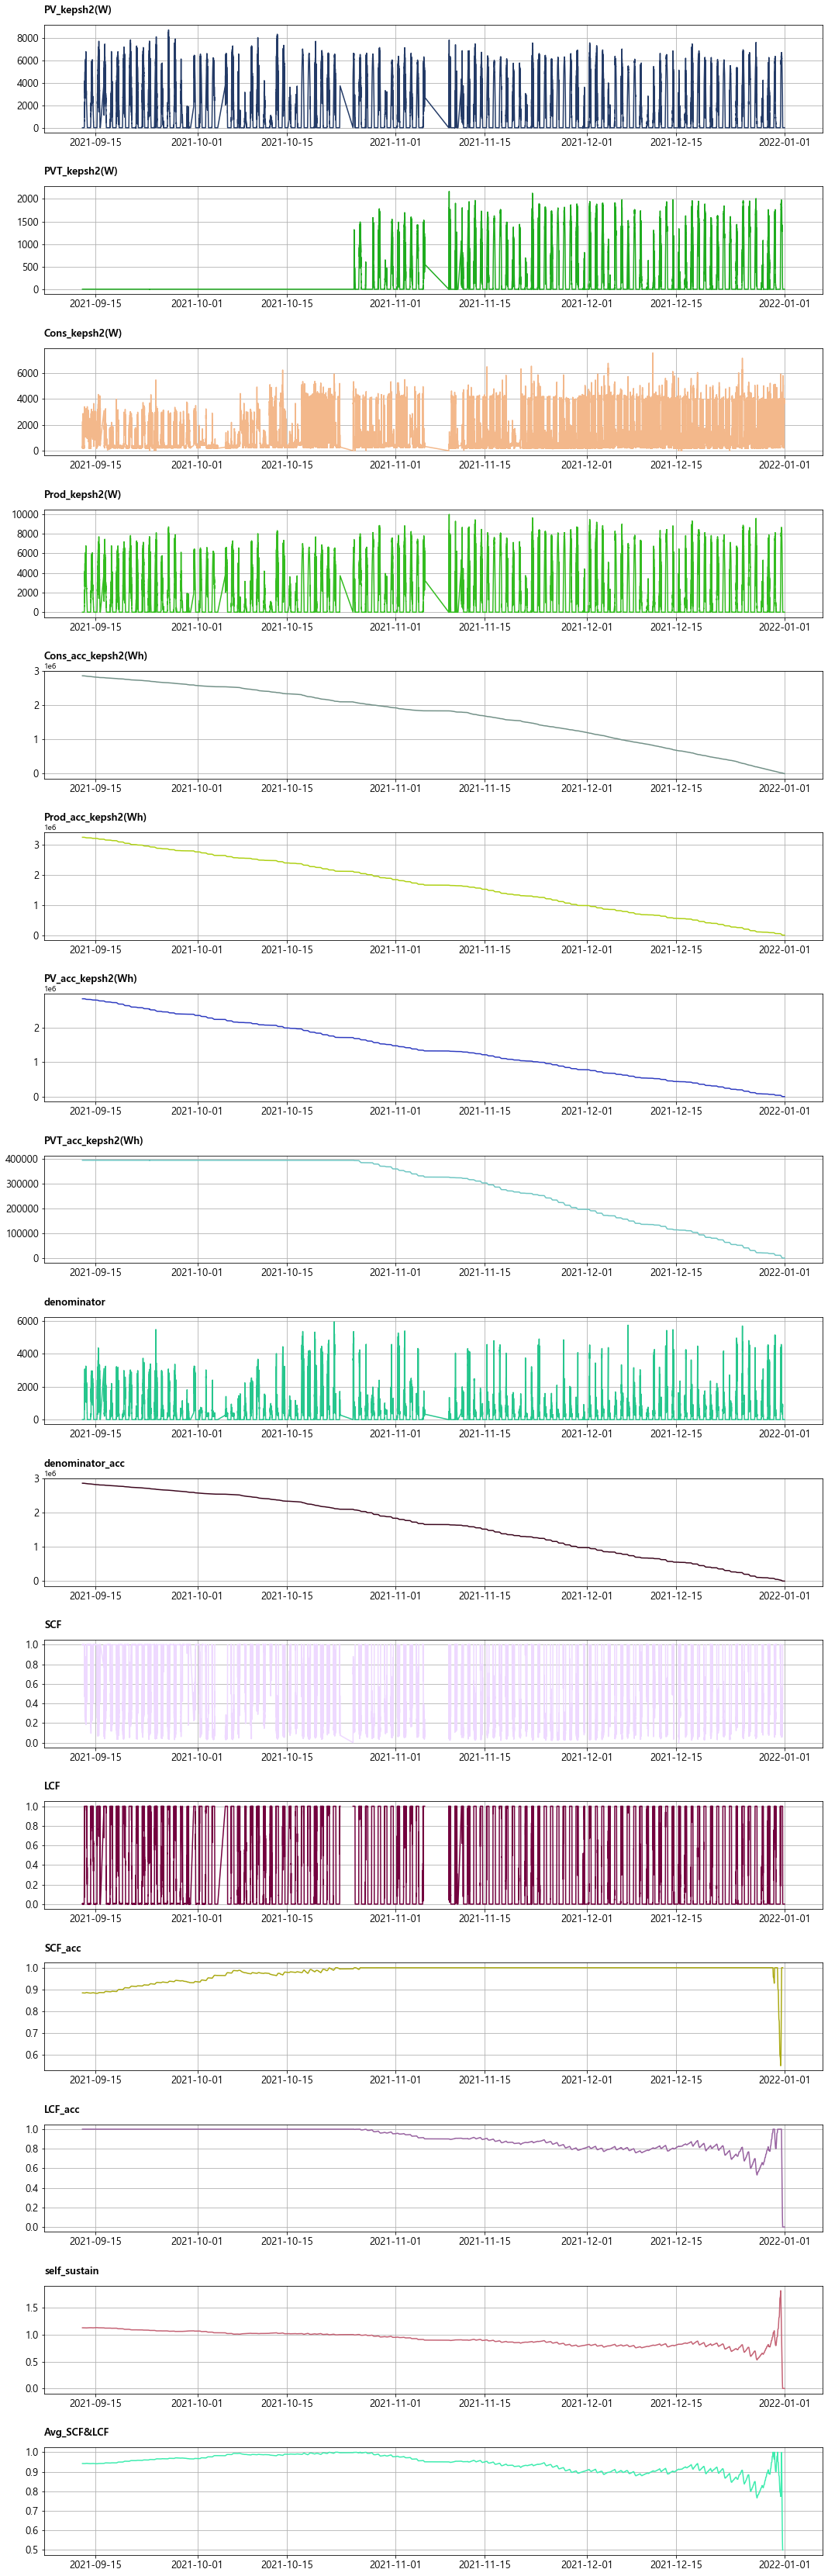

In [148]:
fig, ax = plt.subplots(figsize=(18,60))

for i in range(len(df_kepsh2.columns)):
    plt.subplot(len(df_kepsh2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh2.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh2[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()